ResNet

In [40]:
#load keras model
import keras
from keras.models import load_model
import numpy as np
#load model
model = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained models\ResNet_SE.keras')


In [41]:
import pandas as pd
test_sick = pd.read_pickle(r'C:\Users\Utente\Desktop\Chiara\SUBSET\df_malati_mean_noFMP.pkl')
test_healthy = pd.read_pickle(r'C:\Users\Utente\Desktop\Chiara\SUBSET\df_test_mean.pkl')
train = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_train_mean.pkl")

In [42]:
test_healthy['signals'] = test_healthy['signals'].apply(lambda x: x[0] if isinstance(x, list) and isinstance(x[0], np.ndarray) else x)
test_sick['signals'] = test_sick['signals'].apply(lambda x: x[0] if isinstance(x, list) and isinstance(x[0], np.ndarray) else x)
train['signals'] = train['signals'].apply(lambda x: x[0] if isinstance(x, list) and isinstance(x[0], np.ndarray) else x)

In [43]:
def find_n_windows(l_signal, w_window=3600, Maxoverlap=0.5):
    n_windows = np.ceil(l_signal / w_window)
    if n_windows ==1:
        overlap = 0
    else:
        overlap = np.ceil(((n_windows * w_window) - l_signal) / (n_windows -1))
    if overlap * (n_windows - 1) > (w_window * Maxoverlap):
        n_windows = n_windows -1
        overlap = 0
    return n_windows, overlap


import numpy as np

def WindowSignals(X, y, Maxoverlap=0.5):
    """
    Divide i segnali di X in finestre e assegna a ciascuna finestra l'età gestazionale `y`.
    
    Args:
        X (ndarray): Array di segnali, ciascuno rappresentato come array numpy (dtype=object).
        y (ndarray): Array di etichette (età gestazionale) corrispondenti ai segnali in X (dtype=object).
        Maxoverlap (float): Percentuale massima di sovrapposizione tra le finestre (default 0.5).

    Returns:
        X_post_win (ndarray): Array di finestre dei segnali.
        y_post_win (ndarray): Array di etichette per ciascuna finestra.
    """
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = X.to_numpy()  # Conversione a numpy array se X è un DataFrame o Series
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.to_numpy()  # Conversione a numpy array se y è un DataFrame o Series
    

    X_post_win = []
    y_post_win = []

    for i in range(len(X)):  # Itera sugli array in X (ora sono ndarray di tipo object)
        signal = X[i]
        label = y[i]  # L'etichetta associata al segnale

        l_signal = len(signal)  # Lunghezza del segnale
        w_window = 3600  # Lunghezza della finestra

        # Calcola il numero di finestre e la sovrapposizione
        if Maxoverlap > 0:
            n_windows, overlap = find_n_windows(l_signal, w_window, Maxoverlap)
        else:
            n_windows = np.floor(l_signal / w_window)
            overlap = 0

        # Genera le finestre per il segnale corrente
        for n in range(int(n_windows)):
            start_index = int(n * (w_window - overlap))
            end_index = int(start_index + w_window)
            if end_index > l_signal:  # Verifica che la finestra non esca dai limiti
                break
            window = signal[start_index:end_index]
            X_post_win.append(window)
            y_post_win.append(label)  # Aggiungi l'etichetta corrispondente

    return np.array(X_post_win, dtype=object), np.array(y_post_win, dtype=object)


In [44]:
X_windows_train, y_windows_train= WindowSignals(train['signals'], train['y'])
X_windows_test, y_windows_test = WindowSignals(test_healthy['signals'], test_healthy['y'])
X_windows_test_sick, y_windows_test_sick = WindowSignals(test_sick['signals'], test_sick['y'])

In [45]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(y_windows_train.reshape(-1, 1))
y_windows_test_scaled = scaler.transform(y_windows_test.reshape(-1, 1))
y_windows_test_sick_scaled = scaler.transform(y_windows_test_sick.reshape(-1, 1))

In [46]:
y_windows_test = y_windows_test_scaled
y_windows_test_sick = y_windows_test_sick_scaled

In [47]:
print(X_windows_test.dtype)
print(X_windows_test_sick.dtype)


object
object


In [48]:
import tensorflow as tf

X_windows_test = tf.convert_to_tensor(X_windows_test, dtype=tf.float32)
X_windows_test_sick = tf.convert_to_tensor(X_windows_test_sick, dtype=tf.float32)
X_windows_test = tf.expand_dims(X_windows_test, axis=-1)
X_windows_test_sick = tf.expand_dims(X_windows_test_sick, axis=-1)

In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, linregress, f
import numpy as np

def calculate_p_value_from_r2(R_squared, n, k):
    # Calcola F-statistic
    F_stat = (R_squared / k) / ((1 - R_squared) / (n - k - 1))
    # Calcola p-value
    p_value = 1 - f.cdf(F_stat, dfn=k, dfd=n - k - 1)
    return p_value

def compute_metrics(y_true, y_pred):
    y_true_denorm = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
    y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)
    mse_denorm = mean_squared_error(y_true_denorm, y_pred_denorm)
    mae_denorm_div7 = mae_denorm / 7
    mse_denorm_div7 = mse_denorm / 7
    
    r2 = r2_score(y_true, y_pred)
    
    # Pearson & Spearman
    pearson_corr, p_value_pearson = pearsonr(y_true, y_pred)
    spearman_corr, p_value_spearman = spearmanr(y_true, y_pred)
    
    # Linear regression
    slope, intercept, r_value, p_linreg, std_err = linregress(y_true, y_pred)
    
    # P-value da R^2
    n = len(y_true)
    k = 1  # numero di variabili indipendenti
    p_value_r2 = calculate_p_value_from_r2(r2, n, k)
    
    return {
        'MAE_norm': mae,
        'MSE_norm': mse,
        'MAE_denorm': mae_denorm,
        'MSE_denorm': mse_denorm,
        'MAE_denorm_div7': mae_denorm_div7,
        'MSE_denorm_div7': mse_denorm_div7,
        'R2': r2,
        'P_value_R2': p_value_r2,
        'Pearson': pearson_corr,
        'Spearman': spearman_corr,
        'P_value_pearson': p_value_pearson,
        'P_value_spearman': p_value_spearman,
        'Slope': slope
    }



In [50]:
def matched_resample_equal_dist(y_healthy, y_pred_healthy, y_sick, y_pred_sick, n_samples=50, n_bins=5, random_state=None):
    np.random.seed(random_state)
    
    y_healthy = np.array(y_healthy).flatten()
    y_sick = np.array(y_sick).flatten()
    y_pred_healthy = np.array(y_pred_healthy).flatten()
    y_pred_sick = np.array(y_pred_sick).flatten()

    combined_y = np.concatenate([y_healthy, y_sick])
    bin_edges = np.quantile(combined_y, q=np.linspace(0, 1, n_bins + 1))

    df_h = pd.DataFrame({'y': y_healthy, 'y_pred': y_pred_healthy})
    df_s = pd.DataFrame({'y': y_sick, 'y_pred': y_pred_sick})

    df_h['bin'] = pd.cut(df_h['y'], bins=bin_edges, include_lowest=True)
    df_s['bin'] = pd.cut(df_s['y'], bins=bin_edges, include_lowest=True)

    samples_healthy = []
    samples_sick = []

    for b in df_h['bin'].cat.categories:
        h_bin = df_h[df_h['bin'] == b]
        s_bin = df_s[df_s['bin'] == b]
        if len(h_bin) == 0 or len(s_bin) == 0:
            continue
        k = min(len(h_bin), len(s_bin), n_samples // n_bins)
        samples_healthy.append(h_bin.sample(n=k, replace=False))
        samples_sick.append(s_bin.sample(n=k, replace=False))

    df_h_final = pd.concat(samples_healthy)
    df_s_final = pd.concat(samples_sick)

    return df_h_final['y'].values, df_h_final['y_pred'].values, df_s_final['y'].values, df_s_final['y_pred'].values


In [51]:
def bootstrap_metrics_matched(
    y_h, yhat_h,
    y_s, yhat_s,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=5,
    random_state=None
):
    rng = np.random.default_rng(random_state)
    metrics_all = []
    metrics_h = []
    metrics_s = []
    mean_errors_h_norm = []
    mean_errors_s_norm = []


    for i in range(n_bootstrap):
        y_h_sel, yhat_h_sel, y_s_sel, yhat_s_sel = matched_resample_equal_dist(
            y_h, yhat_h, y_s, yhat_s,
            n_samples=n_samples,
            n_bins=n_bins,
            random_state=rng.integers(0, 1_000_000)
        )

        metrics_h.append(compute_metrics(y_h_sel, yhat_h_sel))
        metrics_s.append(compute_metrics(y_s_sel, yhat_s_sel))

        y_all = np.concatenate([y_h_sel, y_s_sel])
        yhat_all = np.concatenate([yhat_h_sel, yhat_s_sel])
        metrics_all.append(compute_metrics(y_all, yhat_all))
        # Mean error normalizzata per malati (h)
        mean_error_h = float(np.mean(yhat_h_sel - y_h_sel))
        mean_errors_h_norm.append(mean_error_h)
        # Mean error normalizzata per sani (s)
        mean_error_s = float(np.mean(yhat_s_sel - y_s_sel))
        mean_errors_s_norm.append(mean_error_s)


    return metrics_all, metrics_h, metrics_s, mean_errors_h_norm, mean_errors_s_norm


In [52]:
def compute_confidence_intervals(metrics_list, alpha=0.05):
    keys = metrics_list[0].keys()
    ci_dict = {}
    for key in keys:
        values = [m[key] for m in metrics_list]
        lower = np.percentile(values, 100 * alpha / 2)
        upper = np.percentile(values, 100 * (1 - alpha / 2))
        mean = np.mean(values)
        ci_dict[key] = (mean, lower, upper)
    
    return ci_dict


In [53]:
y_true_healthy = y_windows_test.flatten()
y_pred_healthy = model.predict(X_windows_test).flatten()

y_true_sick = y_windows_test_sick.flatten()
y_pred_sick = model.predict(X_windows_test_sick).flatten()


120/120 [==============================] - 6s 47ms/step


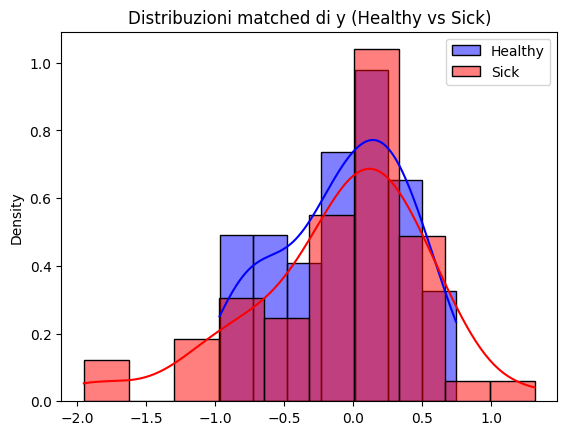

KS test: stat=0.100, p-value=0.967


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

# Singolo resampling per controllo visivo
y_h_sel, _, y_s_sel, _ = matched_resample_equal_dist(
    y_true_healthy, y_pred_healthy,
    y_true_sick, y_pred_sick,
    n_samples=50,
    n_bins=5,
    random_state=123
)

# Plot
sns.histplot(y_h_sel, color="blue", label="Healthy", kde=True, stat="density")
sns.histplot(y_s_sel, color="red", label="Sick", kde=True, stat="density")
plt.legend()
plt.title("Distribuzioni matched di y (Healthy vs Sick)")
plt.show()

# KS test
ks_stat, ks_p = ks_2samp(y_h_sel, y_s_sel)
print(f"KS test: stat={ks_stat:.3f}, p-value={ks_p:.3f}")


In [55]:
import numpy as np
from sklearn.metrics import mean_absolute_error

def bootstrap_mae(y_true, y_pred, n_bootstrap=1000, sample_size=None, random_state=None):
    rng = np.random.default_rng(random_state)
    if sample_size is None:
        sample_size = len(y_true)
    mae_list = []
    for _ in range(n_bootstrap):
        idx = rng.choice(len(y_true), size=sample_size, replace=True)
        mae = mean_absolute_error(y_true[idx], y_pred[idx])
        mae_list.append(mae)
    return mae_list

mae_h = bootstrap_mae(y_true_healthy, y_pred_healthy, n_bootstrap=1000, sample_size=50, random_state=42)
mae_s = bootstrap_mae(y_true_sick, y_pred_sick, n_bootstrap=1000, sample_size=50, random_state=42)


In [57]:
metrics_all, metrics_healthy, metrics_sick, mean_errors_h_norm, mean_errors_s_norm = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy,
    y_true_sick, y_pred_sick,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=5,
    random_state=42
)

ci_all = compute_confidence_intervals(metrics_all)
ci_h = compute_confidence_intervals(metrics_healthy)
ci_s = compute_confidence_intervals(metrics_sick)

print("✅ Confidence Intervals (ALL):", ci_all)
print("🟩 Confidence Intervals (HEALTHY):", ci_h)
print("🟥 Confidence Intervals (SICK):", ci_s)


✅ Confidence Intervals (ALL): {'MAE_norm': (0.35964562833036484, 0.3179727542957749, 0.4027551545767032), 'MSE_norm': (0.23332066278938077, 0.17542784125407904, 0.30147342302836916), 'MAE_denorm': (11.328837252807618, 10.016142505645751, 12.686787719726562), 'MSE_denorm': (231.51243254910213, 174.06828749356004, 299.1369974968334), 'MAE_denorm_div7': (1.6184053218296597, 1.430877500806536, 1.812398245675223), 'MSE_denorm_div7': (33.073204649871734, 24.866898213365722, 42.733856785261914), 'R2': (0.2833294356943838, 0.16952545862514318, 0.3826554434375184), 'P_value_R2': (4.653755466616172e-06, 6.96505630948252e-12, 2.0816689567076934e-05), 'Pearson': (0.5960978870143527, 0.4550231787571363, 0.7145814685024283), 'Spearman': (0.5908287977167055, 0.4482476338311228, 0.7140850628291402), 'P_value_pearson': (5.961366404058512e-07, 6.911024567752842e-17, 1.9727687275187655e-06), 'P_value_spearman': (2.3587968996775743e-06, 7.425869680547871e-17, 2.914871862386883e-06), 'Slope': (0.2275780610

In [58]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")


Healthy subjects:
MAE_norm: 0.314 (IC 95%: 0.268 - 0.358)
MSE_norm: 0.149 (IC 95%: 0.114 - 0.190)
MAE_denorm: 9.878 (IC 95%: 8.449 - 11.286)
MSE_denorm: 148.082 (IC 95%: 113.183 - 188.396)
MAE_denorm_div7: 1.411 (IC 95%: 1.207 - 1.612)
MSE_denorm_div7: 21.155 (IC 95%: 16.169 - 26.914)
R2: 0.297 (IC 95%: 0.124 - 0.449)
P_value_R2: 0.002 (IC 95%: 0.000 - 0.012)
Pearson: 0.575 (IC 95%: 0.369 - 0.735)
Spearman: 0.571 (IC 95%: 0.355 - 0.743)
P_value_pearson: 0.001 (IC 95%: 0.000 - 0.008)
P_value_spearman: 0.001 (IC 95%: 0.000 - 0.011)
Slope: 0.249 (IC 95%: 0.147 - 0.353)

Sick subjects:
MAE_norm: 0.406 (IC 95%: 0.339 - 0.479)
MSE_norm: 0.317 (IC 95%: 0.206 - 0.450)
MAE_denorm: 12.780 (IC 95%: 10.680 - 15.099)
MSE_denorm: 314.943 (IC 95%: 204.460 - 446.532)
MAE_denorm_div7: 1.826 (IC 95%: 1.526 - 2.157)
MSE_denorm_div7: 44.992 (IC 95%: 29.209 - 63.790)
R2: 0.270 (IC 95%: 0.115 - 0.405)
P_value_R2: 0.003 (IC 95%: 0.000 - 0.016)
Pearson: 0.619 (IC 95%: 0.420 - 0.767)
Spearman: 0.607 (IC 95%: 0

Mann–Whitney U test statistic: 22191.00, p-value: 0.0000


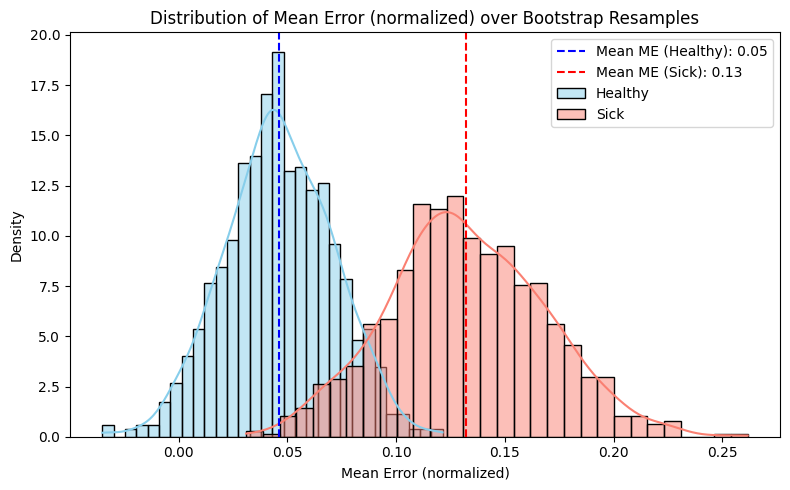

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm, mean_errors_s_norm, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm):.2f}")
plt.axvline(np.mean(mean_errors_s_norm), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


Inception Net

In [62]:
model_inc = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained Models\Inception_ResNet_v1.keras')

In [63]:
#y_true_healthy = y_windows_test.flatten()
y_pred_healthy_inc = model_inc.predict(X_windows_test).flatten()

#y_true_sick = y_windows_test_sick.flatten()
y_pred_sick_inc = model_inc.predict(X_windows_test_sick).flatten()

120/120 [==============================] - 9s 77ms/step


In [64]:
metrics_all_inc, metrics_healthy_inc, metrics_sick_inc, mean_errors_h_norm_inc, mean_errors_s_norm_inc = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy_inc,
    y_true_sick, y_pred_sick_inc,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=5,
    random_state=42
)

ci_all_inc = compute_confidence_intervals(metrics_all_inc)
ci_h_inc = compute_confidence_intervals(metrics_healthy_inc)
ci_s_inc = compute_confidence_intervals(metrics_sick_inc)

print("✅ Confidence Intervals (ALL):", ci_all_inc)
print("🟩 Confidence Intervals (HEALTHY):", ci_h_inc)
print("🟥 Confidence Intervals (SICK):", ci_s_inc)

✅ Confidence Intervals (ALL): {'MAE_norm': (0.4387961596550036, 0.4045407364188458, 0.4749229498046732), 'MSE_norm': (0.34045094779546936, 0.2679952187288788, 0.4272367768908909), 'MAE_denorm': (13.822078992004393, 12.743032089233399, 14.960074249267578), 'MSE_denorm': (337.8124556635647, 265.918296460795, 423.92565882981125), 'MAE_denorm_div7': (1.9745827131434848, 1.8204331556047715, 2.1371534641810825), 'MSE_denorm_div7': (48.2589222376521, 37.98832806582786, 60.560808404258744), 'R2': (-0.04533539369795559, -0.06545734992878612, -0.027457290970512502), 'P_value_R2': (1.0, 1.0, 1.0), 'Pearson': (0.05594368815543493, -0.15709560916010845, 0.2561251988270763), 'Spearman': (0.033277660285746, -0.16655209370525098, 0.22202424012698915), 'P_value_pearson': (0.4449632604008334, 0.010109027766940504, 0.9737713027282725), 'P_value_spearman': (0.48650817141263714, 0.019771087039783027, 0.9721703741435662), 'Slope': (0.0004043121676246585, -0.0011536481477284265, 0.0018723827008046365)}
🟩 Con

In [65]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h_inc.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s_inc.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")


Healthy subjects:
MAE_norm: 0.384 (IC 95%: 0.356 - 0.412)
MSE_norm: 0.219 (IC 95%: 0.188 - 0.253)
MAE_denorm: 12.100 (IC 95%: 11.226 - 12.980)
MSE_denorm: 217.371 (IC 95%: 187.002 - 250.696)
MAE_denorm_div7: 1.729 (IC 95%: 1.604 - 1.854)
MSE_denorm_div7: 31.053 (IC 95%: 26.715 - 35.814)
R2: -0.031 (IC 95%: -0.054 - -0.012)
P_value_R2: 1.000 (IC 95%: 1.000 - 1.000)
Pearson: -0.000 (IC 95%: -0.276 - 0.305)
Spearman: -0.005 (IC 95%: -0.273 - 0.275)
P_value_pearson: 0.510 (IC 95%: 0.021 - 0.978)
P_value_spearman: 0.508 (IC 95%: 0.027 - 0.978)
Slope: 0.000 (IC 95%: -0.002 - 0.003)

Sick subjects:
MAE_norm: 0.493 (IC 95%: 0.433 - 0.562)
MSE_norm: 0.462 (IC 95%: 0.316 - 0.637)
MAE_denorm: 15.544 (IC 95%: 13.639 - 17.703)
MSE_denorm: 458.254 (IC 95%: 313.742 - 632.360)
MAE_denorm_div7: 2.221 (IC 95%: 1.948 - 2.529)
MSE_denorm_div7: 65.465 (IC 95%: 44.820 - 90.337)
R2: -0.062 (IC 95%: -0.098 - -0.031)
P_value_R2: 1.000 (IC 95%: 1.000 - 1.000)
Pearson: 0.094 (IC 95%: -0.211 - 0.394)
Spearman: 0.

Mann–Whitney U test statistic: 6740.00, p-value: 0.0000


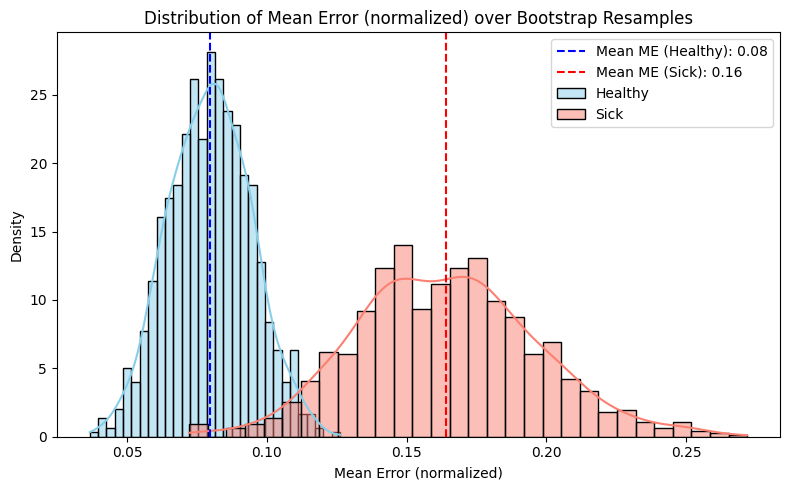

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm_inc, mean_errors_s_norm_inc, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm_inc, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm_inc, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm_inc), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm_inc):.2f}")
plt.axvline(np.mean(mean_errors_s_norm_inc), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm_inc):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

ResNet with activity state

In [67]:
model_qa = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained Models\model_with_QA_mean.keras')

In [68]:
train_q_a = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\DockerImage\softmax_predictions_train_non_norm.pkl")
test_q_a = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\DockerImage\softmax_predictions_test_non_norm.pkl")
test_sick_q_a = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\DockerImage\softmax_predictions_test_sick_non_norm.pkl")

In [69]:
train = pd.concat([train, train_q_a], axis=1)
test = pd.concat([test_healthy, test_q_a], axis=1)
test_sick = pd.concat([test_sick, test_sick_q_a], axis=1)

In [70]:
X_windows_train, y_windows_train= WindowSignals(train['signals'], train['y'])
X_windows_test, y_windows_test = WindowSignals(test['signals'], test['y'])
X_windows_test_sick, y_windows_test_sick = WindowSignals(test_sick['signals'], test_sick['y'])

X_windows_train_qa, y_windows_train= WindowSignals(train['softmax_prediction_list'], train['y'])
X_windows_test_qa, y_windows_test_qa = WindowSignals(test['softmax_prediction_list'], test['y'])
X_windows_test_sick_qa, y_windows_test_sick_qa = WindowSignals(test_sick['softmax_prediction_list'], test_sick['y'])

In [71]:
y_windows_test_scaled = scaler.transform(y_windows_test.reshape(-1, 1))
y_windows_test_sick_scaled = scaler.transform(y_windows_test_sick.reshape(-1, 1))
y_windows_test = y_windows_test_scaled
y_windows_test_sick = y_windows_test_sick_scaled

In [72]:
X_test = np.stack([X_windows_test, X_windows_test_qa], axis=-1)  # (batch_size, timesteps, 2)
X_test_sick = np.stack([X_windows_test_sick, X_windows_test_sick_qa], axis=-1)  # (batch_size, timesteps, 2)

In [73]:
X_windows_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_windows_test_sick = tf.convert_to_tensor(X_test_sick, dtype=tf.float32)

In [74]:
y_windows_test = tf.convert_to_tensor(y_windows_test, dtype=tf.float32)
y_windows_test_sick = tf.convert_to_tensor(y_windows_test_sick, dtype=tf.float32)

In [75]:
#y_true_healthy = y_windows_test.flatten()
y_pred_healthy_qa = model_qa.predict(X_windows_test).flatten()

#y_true_sick = y_windows_test_sick.flatten()
y_pred_sick_qa = model_qa.predict(X_windows_test_sick).flatten()

120/120 [==============================] - 6s 47ms/step


In [76]:
metrics_all_qa, metrics_healthy_qa, metrics_sick_qa, mean_errors_h_norm_qa, mean_errors_s_norm_qa = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy_qa,
    y_true_sick, y_pred_sick_qa,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=5,
    random_state=42
)

ci_all_qa = compute_confidence_intervals(metrics_all_qa)
ci_h_qa = compute_confidence_intervals(metrics_healthy_qa)
ci_s_qa = compute_confidence_intervals(metrics_sick_qa)

print("✅ Confidence Intervals (ALL):", ci_all_qa)
print("🟩 Confidence Intervals (HEALTHY):", ci_h_qa)
print("🟥 Confidence Intervals (SICK):", ci_s_qa)

✅ Confidence Intervals (ALL): {'MAE_norm': (0.3641447923135139, 0.3241697113791986, 0.40640621660872167), 'MSE_norm': (0.2386255341450401, 0.18194497504841464, 0.30449427690948416), 'MAE_denorm': (11.470560851593017, 10.211346286773681, 12.801796630859375), 'MSE_denorm': (236.77618652806555, 180.534907311993, 302.13443301745934), 'MAE_denorm_div7': (1.6386515502275738, 1.4587637552533832, 1.8288280901227678), 'MSE_denorm_div7': (33.82516950400936, 25.79070104457043, 43.16206185963705), 'R2': (0.2668777959507496, 0.17725174143752698, 0.3564707754337728), 'P_value_R2': (2.4641332394793603e-06, 5.515621293028517e-11, 1.2908547839787738e-05), 'Pearson': (0.6017856938373412, 0.4803738243958398, 0.7209374565454506), 'Spearman': (0.5944079235420802, 0.4571389273920369, 0.7178579874679291), 'P_value_pearson': (3.567058671079627e-07, 2.7243560978675408e-17, 4.2388465815256267e-07), 'P_value_spearman': (5.26709294818033e-07, 4.2906918467601894e-17, 1.743140216108196e-06), 'Slope': (0.20079534645

In [77]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h_qa.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s_qa.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")


Healthy subjects:
MAE_norm: 0.315 (IC 95%: 0.273 - 0.356)
MSE_norm: 0.151 (IC 95%: 0.116 - 0.187)
MAE_denorm: 9.927 (IC 95%: 8.594 - 11.201)
MSE_denorm: 149.824 (IC 95%: 114.919 - 185.472)
MAE_denorm_div7: 1.418 (IC 95%: 1.228 - 1.600)
MSE_denorm_div7: 21.403 (IC 95%: 16.417 - 26.496)
R2: 0.289 (IC 95%: 0.138 - 0.441)
P_value_R2: 0.001 (IC 95%: 0.000 - 0.008)
Pearson: 0.581 (IC 95%: 0.392 - 0.741)
Spearman: 0.579 (IC 95%: 0.369 - 0.755)
P_value_pearson: 0.001 (IC 95%: 0.000 - 0.005)
P_value_spearman: 0.001 (IC 95%: 0.000 - 0.008)
Slope: 0.225 (IC 95%: 0.138 - 0.328)

Sick subjects:
MAE_norm: 0.413 (IC 95%: 0.347 - 0.482)
MSE_norm: 0.326 (IC 95%: 0.216 - 0.453)
MAE_denorm: 13.014 (IC 95%: 10.930 - 15.177)
MSE_denorm: 323.729 (IC 95%: 214.775 - 449.369)
MAE_denorm_div7: 1.859 (IC 95%: 1.561 - 2.168)
MSE_denorm_div7: 46.247 (IC 95%: 30.682 - 64.196)
R2: 0.249 (IC 95%: 0.128 - 0.362)
P_value_R2: 0.002 (IC 95%: 0.000 - 0.011)
Pearson: 0.627 (IC 95%: 0.432 - 0.779)
Spearman: 0.606 (IC 95%: 0

Mann–Whitney U test statistic: 17955.00, p-value: 0.0000


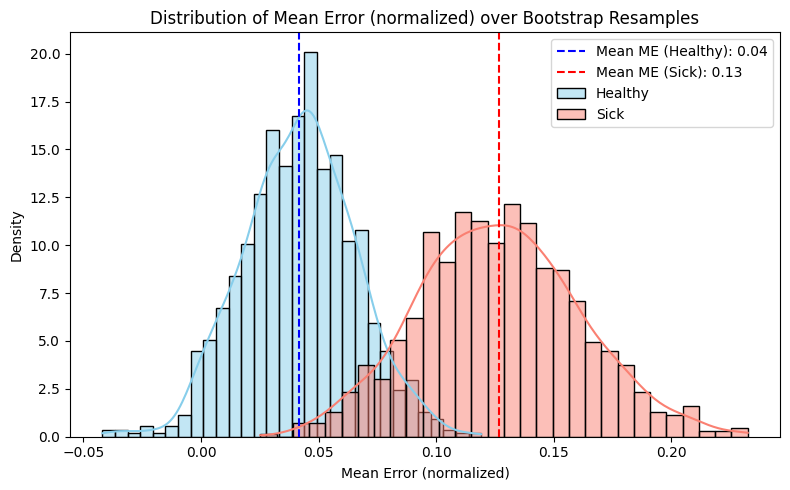

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm_qa, mean_errors_s_norm_qa, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm_qa, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm_qa, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm_qa), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm_qa):.2f}")
plt.axvline(np.mean(mean_errors_s_norm_qa), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm_qa):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

ResNet with FMP

In [79]:
model_fmp = load_model(r'C:\Users\Utente\Desktop\Chiara\Codici\Cose nuove\Nuovi\Final_mean\Codes\Trained Models\model_FMP_mean.keras')

In [80]:
train = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_mean_train_FMP.pkl")
train['FHR'] = train['FHR'].apply(lambda x: x[0] if isinstance(x, list) else x)
train['FMP'] = train['FMP'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [81]:
test = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_mean_test_FMP.pkl")
test['FHR'] = test['FHR'].apply(lambda x: x[0] if isinstance(x, list) else x)
test['FMP'] = test['FMP'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [82]:
test_sick = pd.read_pickle(r"C:\Users\Utente\Desktop\Chiara\SUBSET\df_mean_malati_FMP.pkl")
test_sick['FHR'] = test_sick['FHR'].apply(lambda x: x[0] if isinstance(x, list) else x)
test_sick['FMP'] = test_sick['FMP'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [83]:
X_windows_train_FHR, y_windows_train= WindowSignals(train['FHR'], train['y'])
X_windows_test_FHR, y_windows_test = WindowSignals(test['FHR'], test['y'])
X_windows_test_sick_FHR, y_windows_test_sick = WindowSignals(test_sick['FHR'], test_sick['y'])

In [84]:
X_windows_train_FMP, y_windows_train= WindowSignals(train['FMP'], train['y'])
X_windows_test_FMP, y_windows_test = WindowSignals(test['FMP'], test['y'])
X_windows_test_sick_FMP, y_windows_test_sick = WindowSignals(test_sick['FHR'], test_sick['y'])

In [85]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(y_windows_train.reshape(-1, 1))

y_windows_train_scaled = scaler.transform(y_windows_train.reshape(-1, 1))
y_windows_test_scaled = scaler.transform(y_windows_test.reshape(-1, 1))
y_windows_test_sick_scaled = scaler.transform(y_windows_test_sick.reshape(-1, 1))
y_windows_train = y_windows_train_scaled
y_windows_test = y_windows_test_scaled
y_windows_test_sick = y_windows_test_sick_scaled

In [86]:
X_test = np.stack([X_windows_test_FHR, X_windows_test_FMP], axis=-1)
X_test_sick = np.stack([X_windows_test_sick_FHR, X_windows_test_sick_FMP], axis=-1) 
X_windows_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
X_windows_test_sick = tf.convert_to_tensor(X_test_sick, dtype=tf.float32)

In [87]:
y_windows_test = tf.convert_to_tensor(y_windows_test, dtype=tf.float32)
y_windows_test_sick = tf.convert_to_tensor(y_windows_test_sick, dtype=tf.float32)

In [88]:
#y_true_healthy = y_windows_test.flatten()
y_pred_healthy_fmp = model_fmp.predict(X_windows_test).flatten()

#y_true_sick = y_windows_test_sick.flatten()
y_pred_sick_fmp = model_fmp.predict(X_windows_test_sick).flatten()

120/120 [==============================] - 6s 47ms/step


In [89]:
metrics_all_fmp, metrics_healthy_fmp, metrics_sick_fmp, mean_errors_h_norm_fmp, mean_errors_s_norm_fmp = bootstrap_metrics_matched(
    y_true_healthy, y_pred_healthy_fmp,
    y_true_sick, y_pred_sick_fmp,
    n_samples=50,
    n_bootstrap=1000,
    n_bins=5,
    random_state=42
)

ci_all_fmp = compute_confidence_intervals(metrics_all_fmp)
ci_h_fmp = compute_confidence_intervals(metrics_healthy_fmp)
ci_s_fmp = compute_confidence_intervals(metrics_sick_fmp)

print("✅ Confidence Intervals (ALL):", ci_all_fmp)
print("🟩 Confidence Intervals (HEALTHY):", ci_h_fmp)
print("🟥 Confidence Intervals (SICK):", ci_s_fmp)

✅ Confidence Intervals (ALL): {'MAE_norm': (0.44294816875615534, 0.38861926490367066, 0.5009840972334265), 'MSE_norm': (0.36180339541092577, 0.2593293455651168, 0.48609242505544004), 'MAE_denorm': (13.95286768173218, 12.241505722045899, 15.781000030517577), 'MSE_denorm': (358.99943200768445, 257.31953064062515, 482.32523102469736), 'MAE_denorm_div7': (1.9932668116760253, 1.7487865317208426, 2.2544285757882254), 'MSE_denorm_div7': (51.28563314395491, 36.75993294866073, 68.90360443209963), 'R2': (-0.1154426462410923, -0.4097433382292619, 0.10696734610046132), 'P_value_R2': (0.8103787120009839, 0.0008961245033798611, 1.0), 'Pearson': (0.1567066827746995, -0.03448957536877955, 0.3516078762897353), 'Spearman': (0.2767257849331204, 0.09330514162110422, 0.45588117893372265), 'P_value_pearson': (0.23666861327971753, 0.00033437281252082335, 0.9215082936974305), 'P_value_spearman': (0.04181437135508094, 1.8762695930783665e-06, 0.3558324434779632), 'Slope': (0.07227018939112519, -0.02226961229351

In [90]:
print("Healthy subjects:")
for metrica, (mean, lower, upper) in ci_h_fmp.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

print("\nSick subjects:")
for metrica, (mean, lower, upper) in ci_s_fmp.items():
    print(f"{metrica}: {mean:.3f} (IC 95%: {lower:.3f} - {upper:.3f})")

Healthy subjects:
MAE_norm: 0.314 (IC 95%: 0.271 - 0.354)
MSE_norm: 0.151 (IC 95%: 0.116 - 0.187)
MAE_denorm: 9.895 (IC 95%: 8.535 - 11.151)
MSE_denorm: 150.230 (IC 95%: 115.573 - 185.568)
MAE_denorm_div7: 1.414 (IC 95%: 1.219 - 1.593)
MSE_denorm_div7: 21.461 (IC 95%: 16.510 - 26.510)
R2: 0.287 (IC 95%: 0.140 - 0.421)
P_value_R2: 0.001 (IC 95%: 0.000 - 0.008)
Pearson: 0.598 (IC 95%: 0.407 - 0.746)
Spearman: 0.594 (IC 95%: 0.392 - 0.754)
P_value_pearson: 0.000 (IC 95%: 0.000 - 0.003)
P_value_spearman: 0.001 (IC 95%: 0.000 - 0.005)
Slope: 0.230 (IC 95%: 0.145 - 0.318)

Sick subjects:
MAE_norm: 0.572 (IC 95%: 0.472 - 0.684)
MSE_norm: 0.572 (IC 95%: 0.379 - 0.816)
MAE_denorm: 18.010 (IC 95%: 14.876 - 21.556)
MSE_denorm: 567.769 (IC 95%: 376.433 - 809.904)
MAE_denorm_div7: 2.573 (IC 95%: 2.125 - 3.079)
MSE_denorm_div7: 81.110 (IC 95%: 53.776 - 115.701)
R2: -0.330 (IC 95%: -0.786 - -0.002)
P_value_R2: 0.980 (IC 95%: 0.995 - 1.000)
Pearson: -0.028 (IC 95%: -0.256 - 0.228)
Spearman: 0.029 (IC 

Mann–Whitney U test statistic: 800401.00, p-value: 0.0000


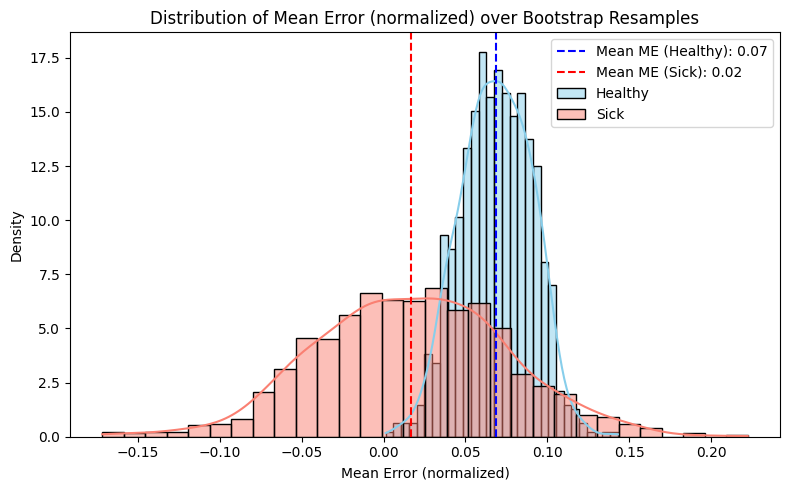

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
import numpy as np

# Mann–Whitney U test
stat, p_value = mannwhitneyu(mean_errors_h_norm_fmp, mean_errors_s_norm_fmp, alternative='two-sided')
print(f"Mann–Whitney U test statistic: {stat:.2f}, p-value: {p_value:.4f}")

# Plot
plt.figure(figsize=(8, 5))
sns.histplot(mean_errors_h_norm_fmp, label="Healthy", color="skyblue", kde=True, stat="density", bins=30)
sns.histplot(mean_errors_s_norm_fmp, label="Sick", color="salmon", kde=True, stat="density", bins=30)

# Mean lines
plt.axvline(np.mean(mean_errors_h_norm_fmp), color="blue", linestyle="--", 
            label=f"Mean ME (Healthy): {np.mean(mean_errors_h_norm_fmp):.2f}")
plt.axvline(np.mean(mean_errors_s_norm_fmp), color="red", linestyle="--", 
            label=f"Mean ME (Sick): {np.mean(mean_errors_s_norm_fmp):.2f}")

# Labels in English
plt.title("Distribution of Mean Error (normalized) over Bootstrap Resamples")
plt.xlabel("Mean Error (normalized)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()